# Japan Suicide Statistics – Exploratory Forecasting

## 1. Overview
This notebook explores forecasting suicide counts in Japan by age group using publicly available datasets. The goal was to test whether machine learning or time-series models could reliably predict future counts.

---

## 2. Data Preparation
- Aggregated data by **year** and **age group**.
- Created lag features to capture temporal trends.
- Noted limitations due to **small dataset size** (few years, many age groups).

---

## 3. Exploratory Analysis
- Visualized trends over time for each age group.
- Observed general population-level patterns and differences by age.

---

## 4. Forecasting Attempts

### 4.0 Linear Regression
- Performance was extremely poor (R² << 0), likely due to **too few data points per feature**.

### 4.1 XGBoost
- Attempted a gradient boosting model.
- Performance was extremely poor (R² << 0), likely due to **too few data points per feature**.
- Model could not learn meaningful patterns.

### 4.2 Prophet
- Attempted time-series forecasting per age group.
- RMSE remained high; R² was negative for all groups.
- Small dataset and low temporal resolution made reliable forecasting impossible.


**Conclusion:** Both models failed to produce meaningful forecasts because the dataset is too small and sparse. Small datasets can mislead predictive modeling.


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


## Load Dataset

In [15]:
df = pd.read_csv("../../data_clean/gender_cleaned.csv")
df = df[['year', '自殺者_総数']].dropna()
df.head()

,year,自殺者_総数
0,1978,20788.0
1,1979,21503.0
2,1980,21048.0
3,1981,20434.0
4,1982,21228.0


In [16]:
df.set_index('year', inplace=True)


In [17]:
df = df.sort_index()

# Split into train and validation

In [18]:
train = df.iloc[:-5]
test = df.iloc[-5:]


In [20]:
print(df.columns)


Index(['自殺者_総数'], dtype='object')


In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = df.index.values.reshape(-1, 1)  # must be 2D
y = df['自殺者_総数'].values

# Then split train/test manually
X_train = X[:-5]
y_train = y[:-5]
X_test = X[-5:]
y_test = y[-5:]



In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Initialize model
model = LinearRegression()

# Fit on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R^2: {r2:.2f}")

# Optional: see coefficients
print(f"Intercept: {model.intercept_:.2f}")
print(f"Slope: {model.coef_[0]:.2f}")


Test MSE: 69801036.79
Test R^2: -205.25
Intercept: -271317.34
Slope: 148.80


## Linear regression is performing very poorly on this data

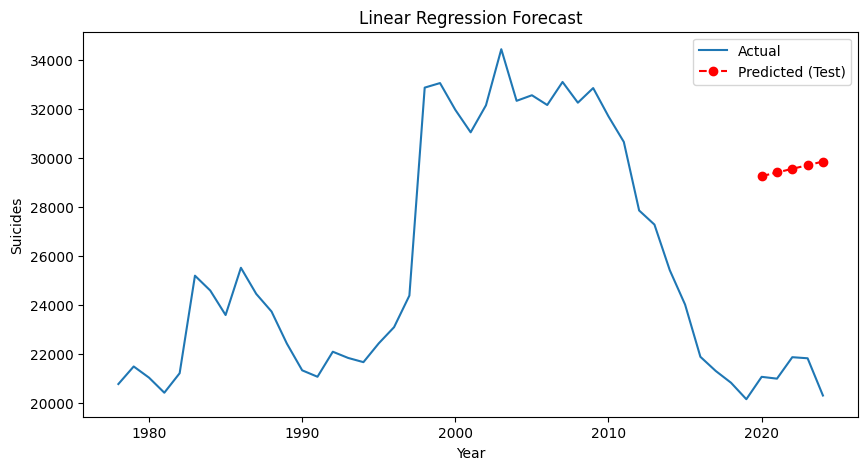

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.index, df['自殺者_総数'], label="Actual")
plt.plot(X_test, y_pred, 'ro--', label="Predicted (Test)")
plt.xlabel("Year")
plt.ylabel("Suicides")
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()


# Trying ARIMA time series

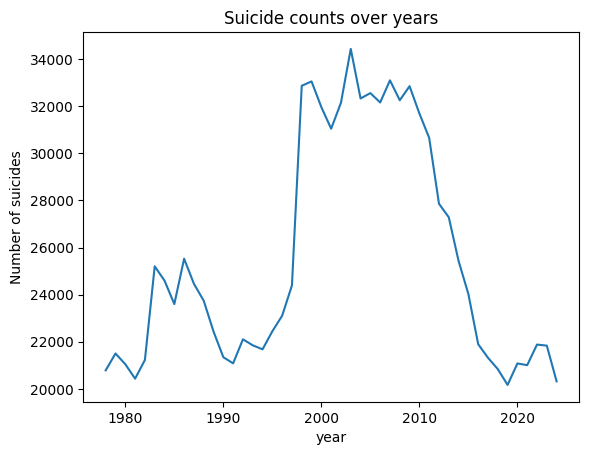

In [34]:
import matplotlib.pyplot as plt

df['自殺者_総数'].plot(title="Suicide counts over years")
plt.ylabel("Number of suicides")
plt.show()


Test MSE: 572044.27
Test pseudo R^2: -0.69


/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


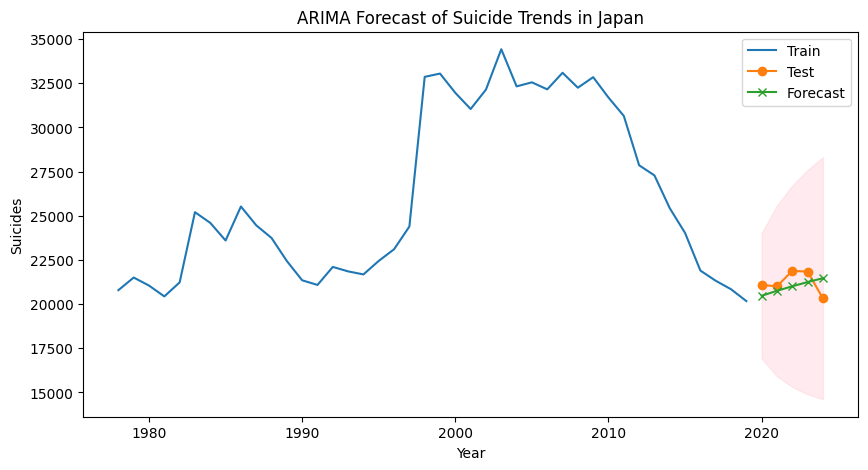

In [43]:
# 1. Imports
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 2. Load dataset
df = pd.read_csv("../../data_clean/gender_cleaned.csv")
df = df[['year', '自殺者_総数']].dropna()

# 3. Set year as index (numeric or datetime)
df['year'] = df['year'].astype(int)  # ensure numeric
df.set_index('year', inplace=True)

# 4. Split into train/test
train = df.iloc[:-5]  # all except last 5 years
test = df.iloc[-5:]   # last 5 years

# 5. Fit ARIMA using auto_arima
arima_model = auto_arima(
    train['自殺者_総数'], 
    seasonal=False,        # no yearly seasonality for now
    stepwise=True, 
    suppress_warnings=True
)

# 6. Forecast for test period
n_periods = len(test)
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# 7. Evaluate performance
mse = mean_squared_error(test['自殺者_総数'], forecast)
print(f"Test MSE: {mse:.2f}")

# Optional: compute pseudo R^2 for time series
r2 = 1 - mse/np.var(test['自殺者_総数'])
print(f"Test pseudo R^2: {r2:.2f}")

# 8. Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train['自殺者_総数'], label='Train')
plt.plot(test.index, test['自殺者_総数'], label='Test', marker='o')
plt.plot(test.index, forecast, label='Forecast', marker='x')
plt.fill_between(test.index, conf_int[:,0], conf_int[:,1], color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Suicides')
plt.title('ARIMA Forecast of Suicide Trends in Japan')
plt.legend()
plt.show()


## Feature Engineering

In [44]:
import pandas as pd

df = pd.read_csv("../../data_clean/gender_cleaned.csv")
df = df[['year', '自殺者_総数', '自殺者_男性', '自殺者_女性']].dropna()

# Set year as datetime index
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)

# Check
df.head()


,自殺者_総数,自殺者_男性,自殺者_女性
year,,,
1978-01-01,20788.0,12859.0,7929.0
1979-01-01,21503.0,13386.0,8117.0
1980-01-01,21048.0,13155.0,7893.0
1981-01-01,20434.0,12942.0,7492.0
1982-01-01,21228.0,13654.0,7574.0


In [45]:
features = ['自殺者_男性', '自殺者_女性']
X = df[features]
y = df['自殺者_総数']

In [46]:
# Time-series split: use the first 80% as train, last 20% as test
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (37, 2), Test shape: (10, 2)


In [48]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np


In [49]:
# Fit ARIMA model on training data
model = ARIMA(train['自殺者_総数'], order=(1,1,1))  # (p,d,q)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 自殺者_総数   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -366.102
Date:                Thu, 11 Dec 2025   AIC                            738.203
Time:                        18:22:13   BIC                            743.344
Sample:                             0   HQIC                           740.075
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0944      2.833     -0.033      0.973      -5.647       5.458
ma.L1          0.1813      2.846      0.064      0.949      -5.396       5.759
sigma2      3.618e+06   4.71e+05      7.676      0.0

/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generat

In [50]:
# Forecast length = test set size
forecast = model_fit.forecast(steps=len(test))

# Evaluate performance
mse = mean_squared_error(test['自殺者_総数'], forecast)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")


Test RMSE: 1247.742117541035


/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


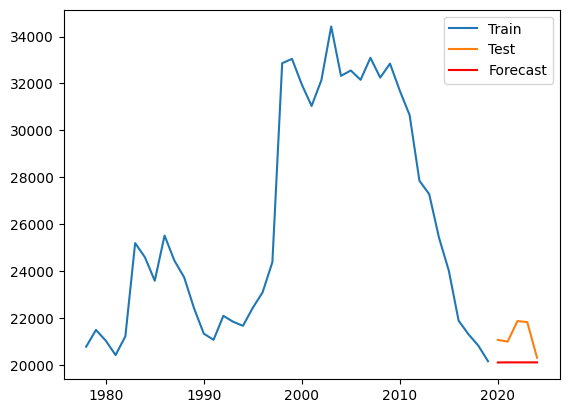

In [51]:
import matplotlib.pyplot as plt

plt.plot(train.index, train['自殺者_総数'], label='Train')
plt.plot(test.index, test['自殺者_総数'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()


## Attempting modelling with SARIMAX

                               SARIMAX Results                                
Dep. Variable:                 自殺者_総数   No. Observations:                   42
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 412.215
Date:                Thu, 11 Dec 2025   AIC                           -780.429
Time:                        18:36:47   BIC                           -743.831
Sample:                             0   HQIC                          -767.298
                                 - 42                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -1.287e-11   4.43e-08     -0.000      1.000   -8.68e-08    8.68e-08
0～9歳             1.0000   6.71e-06   1.49e+05      0.000       1.000       1.000
10～19歳           1.0000   6.71e-06   1.49e+0

/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

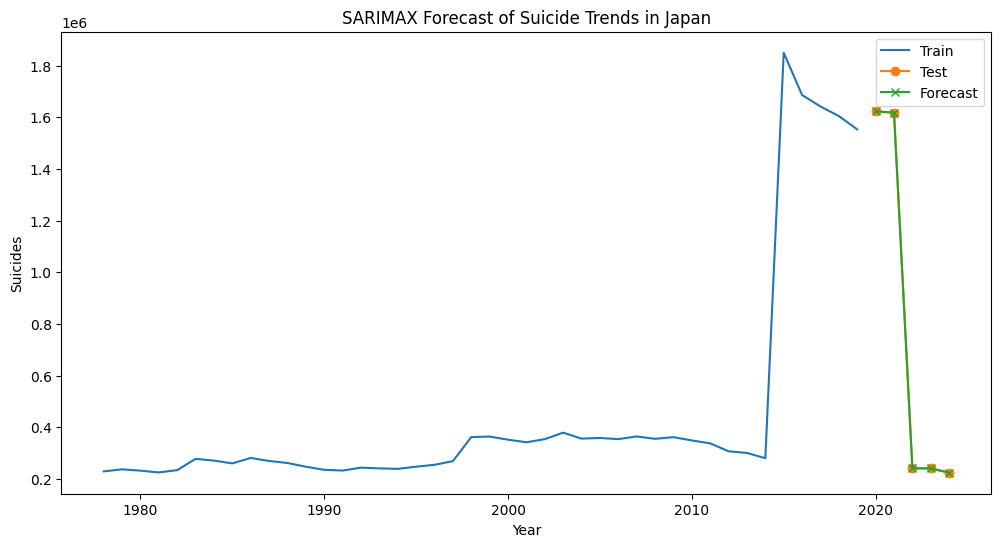

In [52]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 2. Load dataset
df = pd.read_csv("../../data_clean/master_cleaned_dataset.csv")

# 3. Keep relevant columns
df = df[['year', '年齢層', '自殺者_総数', '問題分類']]

# Drop rows with missing suicides
df = df.dropna(subset=['自殺者_総数'])

# 4. Pivot age groups and reason categories as features
# Aggregate suicides by year for each age group
df_age = df.pivot_table(index='year', columns='年齢層', values='自殺者_総数', aggfunc='sum')

# Aggregate suicides by year for each reason category
df_reason = df.pivot_table(index='year', columns='問題分類', values='自殺者_総数', aggfunc='sum')

# 5. Merge features with total suicides
df_total = df.groupby('year')['自殺者_総数'].sum()
data = df_total.to_frame().join(df_age).join(df_reason)

# Fill missing values with 0
data = data.fillna(0)

# 6. Split into train/test
train = data.iloc[:-5]
test = data.iloc[-5:]

y_train = train['自殺者_総数']
y_test = test['自殺者_総数']

# Exogenous variables: age + reason
exog_train = train.drop(columns=['自殺者_総数'])
exog_test = test.drop(columns=['自殺者_総数'])

# 7. Fit SARIMAX
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1,1,1),  # ARIMA(p,d,q), can tune
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

# 8. Forecast
forecast = results.get_forecast(steps=len(test), exog=exog_test)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 9. Evaluate
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f}")

pseudo_r2 = 1 - mse/np.var(y_test)
print(f"Test pseudo R^2: {pseudo_r2:.2f}")

# 10. Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test', marker='o')
plt.plot(test.index, forecast_mean, label='Forecast', marker='x')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Suicides')
plt.title('SARIMAX Forecast of Suicide Trends in Japan')
plt.legend()
plt.show()


the results are too perfect.

Aggregating by age now.

/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an i

Overall Test RMSE: 946234.2523920807
RMSE by Age Group: {'0～9歳': np.float64(90840.15610131106), '10～19歳': np.float64(90840.15610131106), '20～29歳': np.float64(90840.15610131106), '30～39歳': np.float64(90840.15610131106), '40～49歳': np.float64(90840.15610131106), '50～59歳': np.float64(90840.15610131106), '60～69歳': np.float64(90840.15610131106), '70～79歳': np.float64(90840.15610131106), '80歳以上': np.float64(90840.15610131106), '不詳': np.float64(90840.15610131106)}


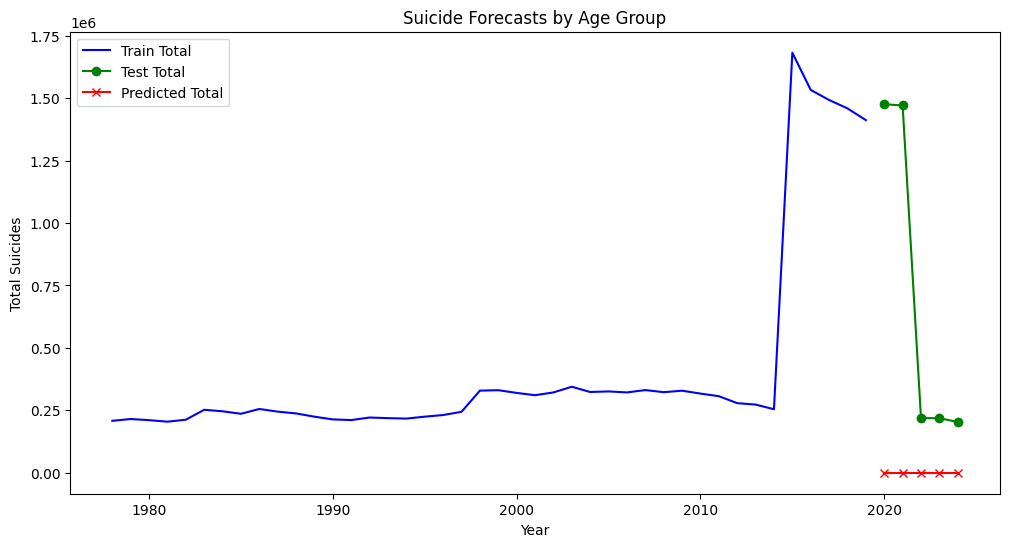

In [53]:
# 1. Imports
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 2. Load dataset
df = pd.read_csv("../../data_clean/master_cleaned_dataset.csv")

# 3. Aggregate by age groups, dropping the '合計' row
df_age = df[df['年齢層'] != '合計']

# Sum suicides per year for each age group
df_age_grouped = df_age.groupby(['year', '年齢層'])['自殺者_総数'].sum().reset_index()

# Pivot to wide format: rows = years, columns = age groups
df_wide = df_age_grouped.pivot(index='year', columns='年齢層', values='自殺者_総数').fillna(0)

# 4. Train-test split
train = df_wide.iloc[:-5]
test = df_wide.iloc[-5:]

# 5. Fit SARIMAX for each age group separately
predictions = pd.DataFrame(index=test.index)
rmse_scores = {}

for age_group in df_wide.columns:
    model = SARIMAX(train[age_group], order=(1,1,1), seasonal_order=(0,0,0,0))
    model_fit = model.fit(disp=False)
    
    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    predictions[age_group] = forecast
    
    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(test[age_group], forecast))
    rmse_scores[age_group] = rmse

# 6. Total predicted suicides
predictions['Total_Predicted'] = predictions.sum(axis=1)
test['Total_Actual'] = test.sum(axis=1)

# 7. Evaluate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(test['Total_Actual'], predictions['Total_Predicted']))
print("Overall Test RMSE:", overall_rmse)
print("RMSE by Age Group:", rmse_scores)

# 8. Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train.sum(axis=1), label='Train Total', color='blue')
plt.plot(test.index, test['Total_Actual'], label='Test Total', marker='o', color='green')
plt.plot(test.index, predictions['Total_Predicted'], label='Predicted Total', marker='x', color='red')
plt.xlabel('Year')
plt.ylabel('Total Suicides')
plt.title('Suicide Forecasts by Age Group')
plt.legend()
plt.show()


## Trying out XGBoost with lag features

19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:38 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 737109.22
Test R^2: -0.18
Test RMSE: 737109.22
Test R^2: -0.18


/home/yulia-chekhovska/Public-Health-Data-Engineering-Project-Japan-Suicide-Statistics-Pipeline/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


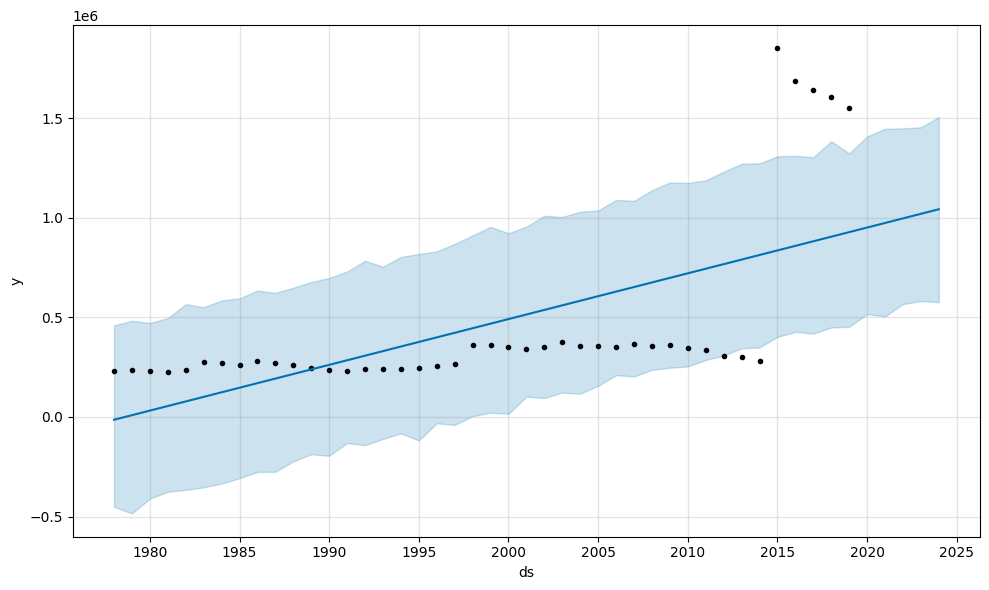

In [75]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Aggregate duplicates and prepare data ---
df = df[['year','年齢層','自殺者_総数']].dropna()
df_agg = df.groupby(['year','年齢層'], as_index=False)['自殺者_総数'].sum()

# --- 2. Pivot to wide format ---
df_wide = df_agg.pivot(index='year', columns='年齢層', values='自殺者_総数').fillna(0)

# --- 3. Total suicides ---
df_wide['total'] = df_wide.sum(axis=1)
df_prophet = df_wide.reset_index()[['year', 'total']]
df_prophet.rename(columns={'year':'ds', 'total':'y'}, inplace=True)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')  # Prophet requires datetime

# --- 4. Train/test split ---
train = df_prophet.iloc[:-5]  # last 5 years as test
test = df_prophet.iloc[-5:]

# --- 5. Fit Prophet ---
model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
model.fit(train)

# --- 6. Make future dataframe ---
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# --- 7. Evaluate ---
y_true = test['y'].values
y_pred = forecast['yhat'].iloc[-5:].values


# RMSE manually
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.2f}")


print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.2f}")

# --- 8. Plot forecast ---
model.plot(forecast)
plt.show()


Prophet is not capturing the trend well yet. Adding age groups separately.

In [76]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Keep only necessary columns
df = df[['year', '年齢層', '自殺者_総数']].dropna()

# Dictionary to store results
results = {}

# Loop over each age group
for age_group in df['年齢層'].unique():
    df_age = df[df['年齢層'] == age_group].copy()
    df_age = df_age.rename(columns={'year': 'ds', '自殺者_総数': 'y'})
    df_age['ds'] = pd.to_datetime(df_age['ds'], format='%Y')
    
    # Train/test split (last 5 years as test)
    train = df_age.iloc[:-5]
    test = df_age.iloc[-5:]
    
    # Fit Prophet
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Forecast
    future = model.make_future_dataframe(periods=5, freq='YE')
    forecast = model.predict(future)
    
    # Evaluate on test set
    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[-5:].values

    # RMSE manually
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    results[age_group] = {'RMSE': rmse, 'R2': r2}
    print(f"Age group: {age_group}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Optional: convert to DataFrame for easier viewing
results_df = pd.DataFrame(results).T
print(results_df)


19:08:53 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:53 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:53 - cmdstanpy - INFO - Chain [1] start processing


Age group: 0～9歳, RMSE: 4730.35, R²: -64.13
Age group: 10～19歳, RMSE: 4730.35, R²: -64.13


19:08:54 - cmdstanpy - INFO - Chain [1] done processing
19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing
19:08:54 - cmdstanpy - INFO - Chain [1] start processing


Age group: 20～29歳, RMSE: 4730.35, R²: -64.13
Age group: 30～39歳, RMSE: 4730.35, R²: -64.13


19:08:54 - cmdstanpy - INFO - Chain [1] done processing
19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing


Age group: 40～49歳, RMSE: 4730.35, R²: -64.13


19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing


Age group: 50～59歳, RMSE: 4730.35, R²: -64.13
Age group: 60～69歳, RMSE: 4730.35, R²: -64.13


19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:55 - cmdstanpy - INFO - Chain [1] done processing
19:08:55 - cmdstanpy - INFO - Chain [1] start processing
19:08:55 - cmdstanpy - INFO - Chain [1] done processing
19:08:55 - cmdstanpy - INFO - Chain [1] start processing


Age group: 70～79歳, RMSE: 4730.35, R²: -64.13
Age group: 80歳以上, RMSE: 4730.35, R²: -64.13


19:08:55 - cmdstanpy - INFO - Chain [1] done processing
19:08:55 - cmdstanpy - INFO - Chain [1] start processing
19:08:55 - cmdstanpy - INFO - Chain [1] done processing


Age group: 不詳, RMSE: 4730.35, R²: -64.13
Age group: 合計, RMSE: 4730.35, R²: -64.13
               RMSE         R2
0～9歳    4730.354404 -64.127247
10～19歳  4730.354404 -64.127247
20～29歳  4730.354404 -64.127247
30～39歳  4730.354404 -64.127247
40～49歳  4730.354404 -64.127247
50～59歳  4730.354404 -64.127247
60～69歳  4730.354404 -64.127247
70～79歳  4730.354404 -64.127247
80歳以上   4730.354404 -64.127247
不詳      4730.354404 -64.127247
合計      4730.354404 -64.127247
